# Lab 4: Working with 'real' data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['data']>

In [4]:
data = np.array(hf.get('data'))

In [5]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [6]:
hf.close()

## Problem 1

> In this problem we are looking at the data from a gamma-ray satellite orbiting in low Earth orbit. It takes a reading of the number of particles detected every 100 milliseconds, and is in an approximately 90 minute orbit. While it is looking for gamma-ray bursts, virtually all of the particles detected are background cosmic rays.  
  

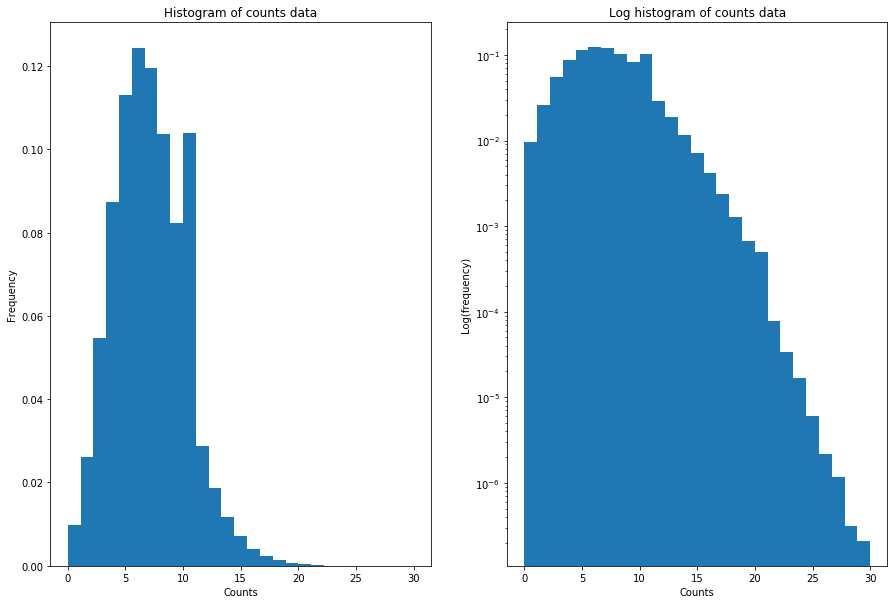

In [7]:
# data[0] = gps time
# data[1] = solar phase
# data[2] = earth longitude
# data[3] = counts


timeData = data[0]
solarPhase = data[1]
longitude = data[2]
counts = data[3]


fig, ax = plt.subplots(1, 2)
histCount = ax[0].hist(counts, density=True, bins=27)
ax[0].set_title("Histogram of counts data")
ax[0].set_xlabel("Counts")
ax[0].set_ylabel("Frequency")


ax[1].hist(counts, density=True, bins=27)
ax[1].set_yscale('log')
ax[1].set_title("Log histogram of counts data")
ax[1].set_xlabel("Counts")
ax[1].set_ylabel("Log(frequency)")

fig.set_size_inches(15,10)

From these histograms, it certainly looks like that our data follows a Poisson distribution, which is certainly expected since we are talking about cosmic ray events (since individual rays shoudl be independent of each other and we are measuring the counts in different time intervals).  There are, however, glaring anomalies (specifically around 11 and 21 counts).

We can show that it follows this distribution by finding the mean of our data set and plotting a corrosponding Poisson distribution.  We can find the $R^2$ value in order to show how good of a fit this is.  $R^2$ is a fitness measurement defined as $1 - \frac{SSR}{SST}$ where SSR is the squared sum of the residuals (the actual minus expected value at that point, squared) and SST is the squared sum of total (the average value of the distribution minus the value at each point, squared).

In [8]:
def r_squared(y_expected, y_actual):
    y_bar = sum(y_actual) / y_actual.size
    ss_tot = sum((y_actual - y_bar)**2)
    ss_res = sum((y_actual - y_expected)**2)
    return 1 - (ss_res / ss_tot)

mu:  7.09730524315952
R-squared:  0.9325670498084291


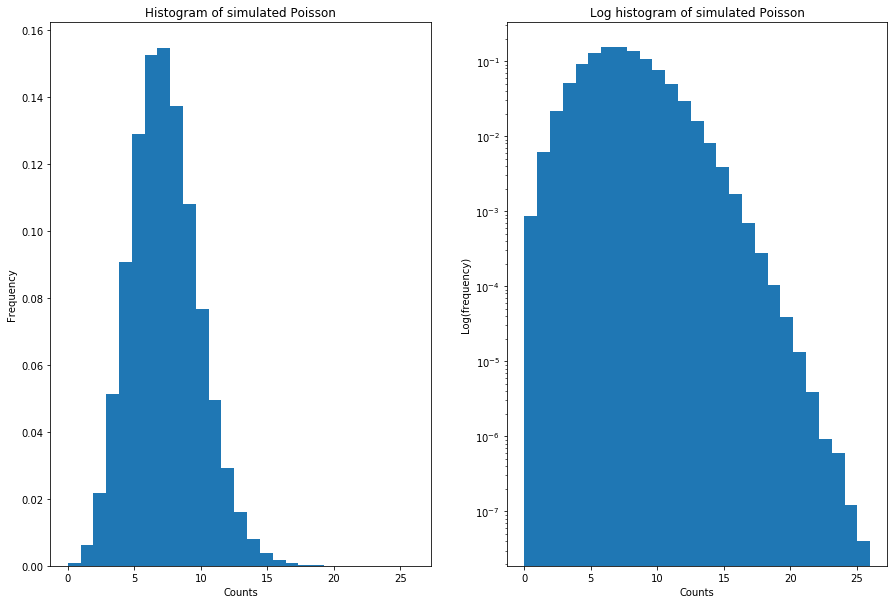

In [9]:
mu = np.mean(data[3])
print("mu: ",mu)

values = stats.poisson.rvs(mu, size=len(data[3]))

fig, ax = plt.subplots(1, 2)
histTheory = ax[0].hist(values, density=True, bins=27)
ax[0].set_title("Histogram of simulated Poisson")
ax[0].set_xlabel("Counts")
ax[0].set_ylabel("Frequency")


ax[1].hist(values, density=True, bins=27)
ax[1].set_yscale('log')
ax[1].set_title("Log histogram of simulated Poisson")
ax[1].set_xlabel("Counts")
ax[1].set_ylabel("Log(frequency)")

fig.set_size_inches(15,10)

diff_square = (histTheory[1] - histCount[1])**2
average = np.mean(diff_square)
print("R-squared: ",r_squared(histTheory[1], histCount[1]))

As we can see, our $R^2$ is 0.9326, which means our data pretty closely matches a Poisson distribution. However, this does not tell the whole story, we also need to see if there are different effect based on orbital location.

In [10]:
def binPlot(dataX, dataY, numBins, start, end):
    npDataX = np.array(dataX[start:end])
    npDataY = np.array(dataY[start:end])
    location = start
    binDataX = np.empty(numBins)
    binDataY = np.empty(numBins)

    binsArrX = np.array_split(npDataX, numBins)
    binsArrY = np.array_split(npDataY, numBins)
    
    index = 0
    for arr in binsArrX:
        binDataX[index] = np.average(arr)
        index += 1
        
    index = 0
    for arr in binsArrY:
        binDataY[index] = np.average(arr)
        index += 1
        
    return [binDataX, binDataY]

In [11]:
def plotPoints(xVals, yVals, plot):
    for index in range(xVals.size):
        plot.plot(xVals[index], yVals[index], 'ro')

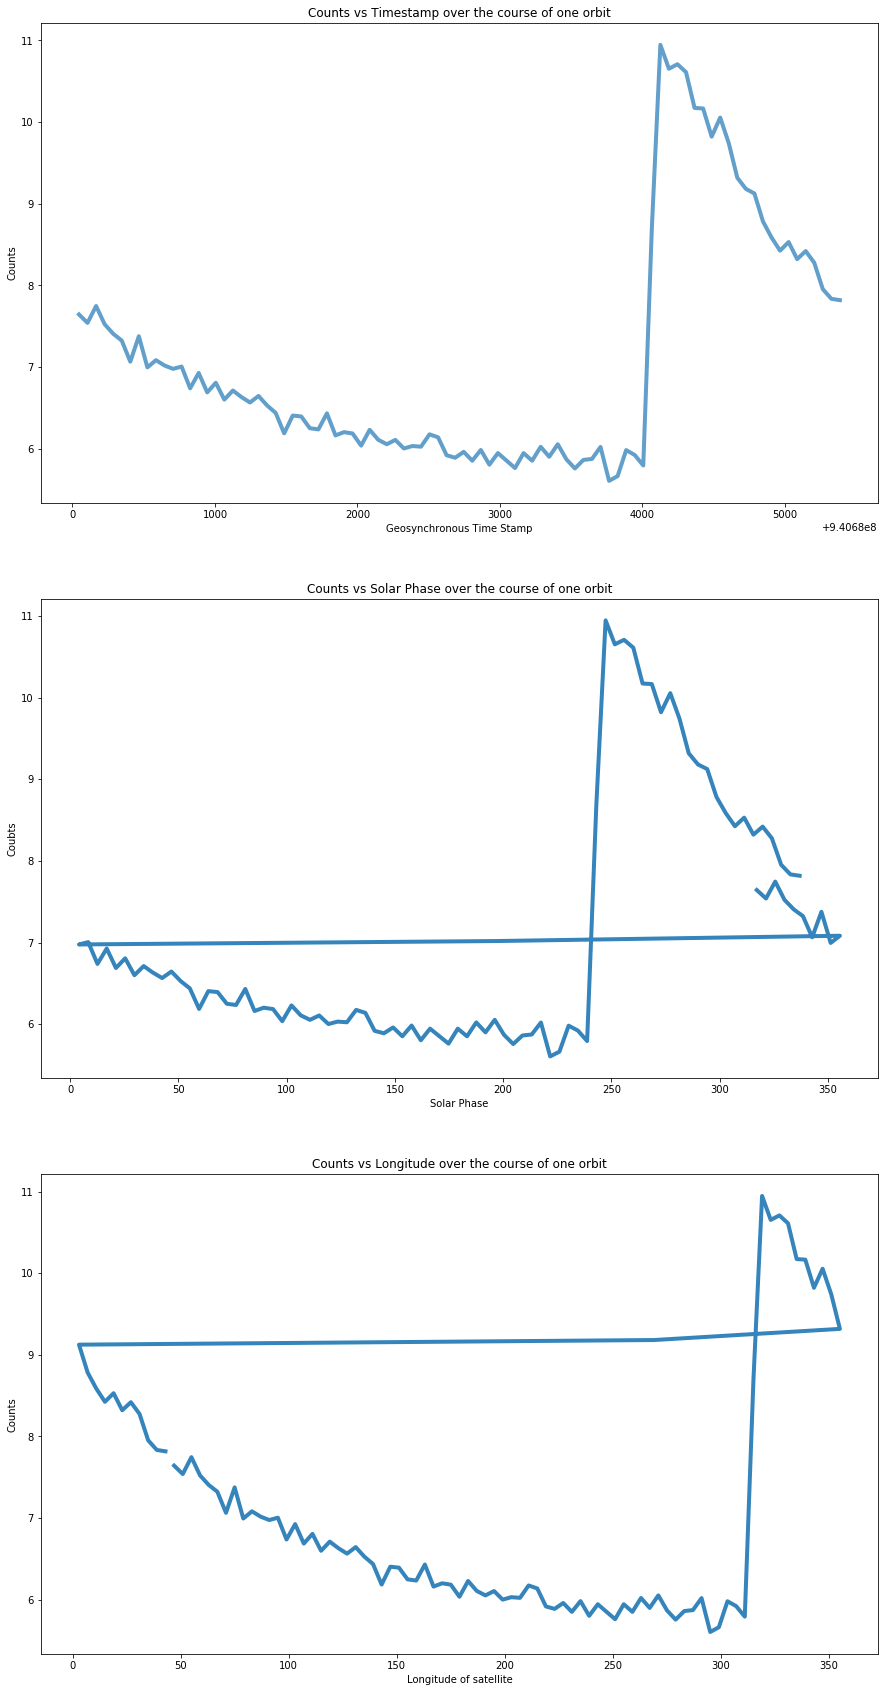

In [12]:
size = 90
oneOrbit = 90*60*10
oneDay = 24*60*60*10

[datAX, datAY] = binPlot(timeData, counts, size, 0, oneOrbit)
[datBX, datBY] = binPlot(solarPhase, counts, size, 0, oneOrbit)
[datCX, datCY] = binPlot(longitude, counts, size, 0, oneOrbit)

fig, ax = plt.subplots(3, 1)
ax[0].plot(datAX, datAY, linewidth=4, alpha = 0.7)
ax[0].set_title("Counts vs Timestamp over the course of one orbit")
ax[0].set_xlabel("Geosynchronous Time Stamp")
ax[0].set_ylabel("Counts")

ax[1].plot(datBX, datBY, linewidth = 4, alpha = 0.9)
ax[1].set_title("Counts vs Solar Phase over the course of one orbit")
ax[1].set_xlabel("Solar Phase")
ax[1].set_ylabel("Coubts")

ax[2].plot(datCX, datCY, linewidth = 4, alpha = 0.9)
ax[2].set_title("Counts vs Longitude over the course of one orbit")
ax[2].set_xlabel("Longitude of satellite")
ax[2].set_ylabel("Counts")


fig.set_size_inches(15,30)

As we can see from the graphs above, we have an anomolay in our data that appears around 320 degrees longitude and 240 degrees solar phase, to better show this, we can average data from all 480 orbits instead of just using a single orbit.  What we really want is a time dependence, so we will zero our time data to the anomaly and then average it over the orbits

Text(0, 0.5, 'Counts')

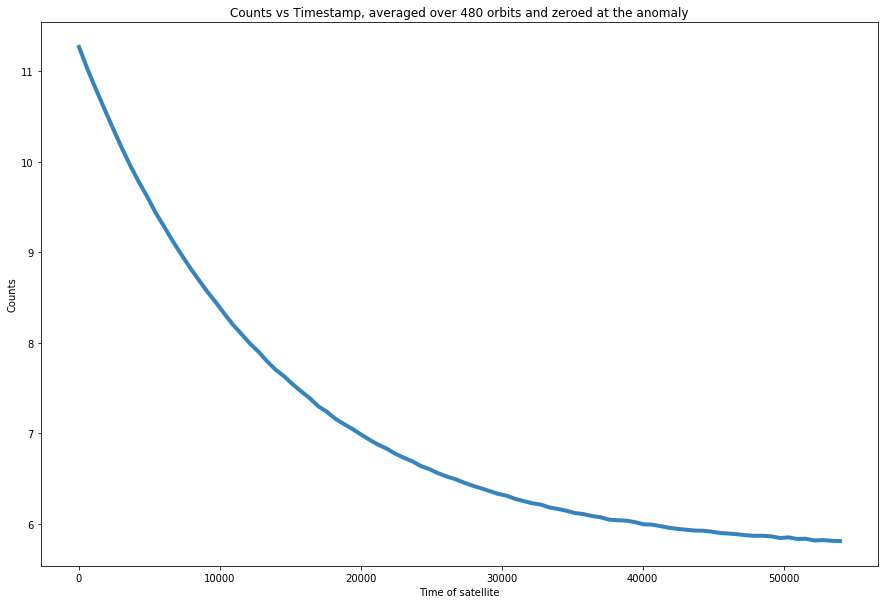

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

totalOrbits = 0
averageY = np.zeros(size)
anomaly_location = 40500

while totalOrbits < (round(len(counts) / oneOrbit) - 1):
    [orbitX, orbitY] = binPlot(timeData, counts, size, (totalOrbits*oneOrbit)+anomaly_location, ((totalOrbits + 1)*oneOrbit) + anomaly_location)
    averageY += (orbitY)
    totalOrbits += 1
    
averageY /= totalOrbits

ax.plot(np.linspace(0, oneOrbit, averageY.size), averageY, linewidth = 4, alpha = 0.9)
ax.set_title("Counts vs Timestamp, averaged over 480 orbits and zeroed at the anomaly")
ax.set_xlabel("Time of satellite")
ax.set_ylabel("Counts")

Now we have a much smoother graph, we can start to develop a time dependance for our background distribution.  The data looks like it could be some sort of exponential decay, which would be of the form $f(x) = a \cdot e^{-b \cdot x}+c$

In [14]:
def exponential_func(x, a, b, c):
    return a*np.exp(-b*x)+c

[5.56987054e+00 7.31677610e-05 5.69830999e+00]


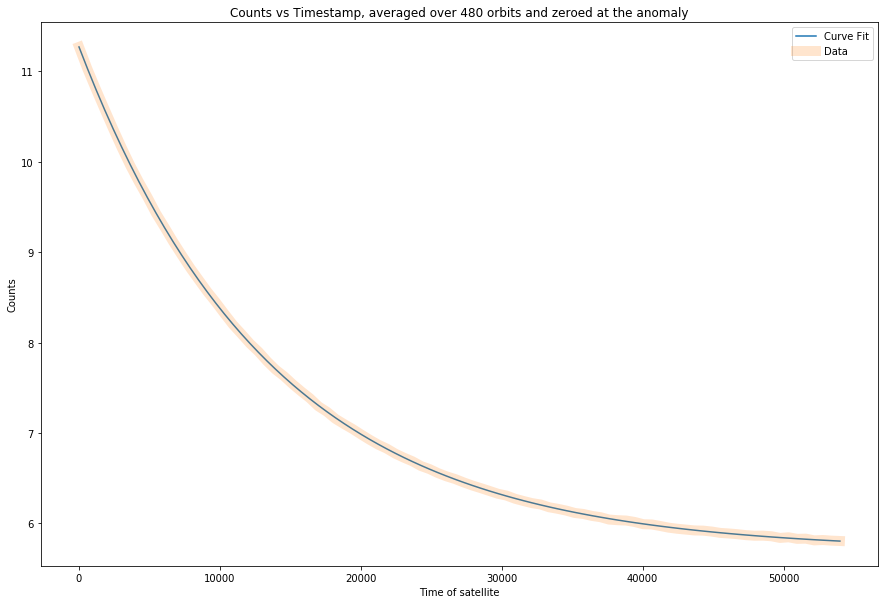

In [15]:
from scipy.optimize import curve_fit as cv

p_opt, pcov = cv(exponential_func, np.linspace(0, oneOrbit, averageY.size), averageY, p0=(4, 0.00002, 5))

print(p_opt)

xNew = np.linspace(0, oneOrbit, averageY.size)
yNew = exponential_func(xNew, p_opt[0], p_opt[1], p_opt[2])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

ax.set_title("Counts vs Timestamp, averaged over 480 orbits and zeroed at the anomaly")
ax.set_xlabel("Time of satellite")
ax.set_ylabel("Counts")
ax.plot(xNew, yNew, label="Curve Fit")
ax.plot(np.linspace(0, oneOrbit,averageY.size), averageY, linewidth = 10, alpha = 0.2, label="Data")
plt.legend()

so our relationship with time dependence is: 

\begin{equation}
    C(t) = 5.5699 \cdot e^{7.317 \cdot 10^{-5}\cdot(( \cdot t + 40500) \mod 54000)} + 5.6983
\end{equation}

the reason for the $+40500$ is because that is the offset we originally gave our data and the reason for the $ \mod 54000$ is because we want the time to reset after each orbit.

Now that we have a model for the background with our time dependence, we can compare it to our recorded background data and see how it matches up

In [16]:
def background(t, p_opt):
    return p_opt[0] * np.exp((p_opt[1] * t + 40500) % 54000) + p_opt[2]

In [17]:
print('R^2 value: ',r_squared(yNew, averageY))

R^2 value:  0.9999892343255167


So with an $R^2$ value of 0.999989, my model matches the background data incredibly well.  

As was stated at the beginning of the report, the general model for radiation is a Poisson distribution.  The time dependent model only tells us how the mean value for the Poisson changes with time.  We can use this time dependent model to determine the $5 \sigma$ threshold for different time locations.

Text(0, 0.5, 'Counts')

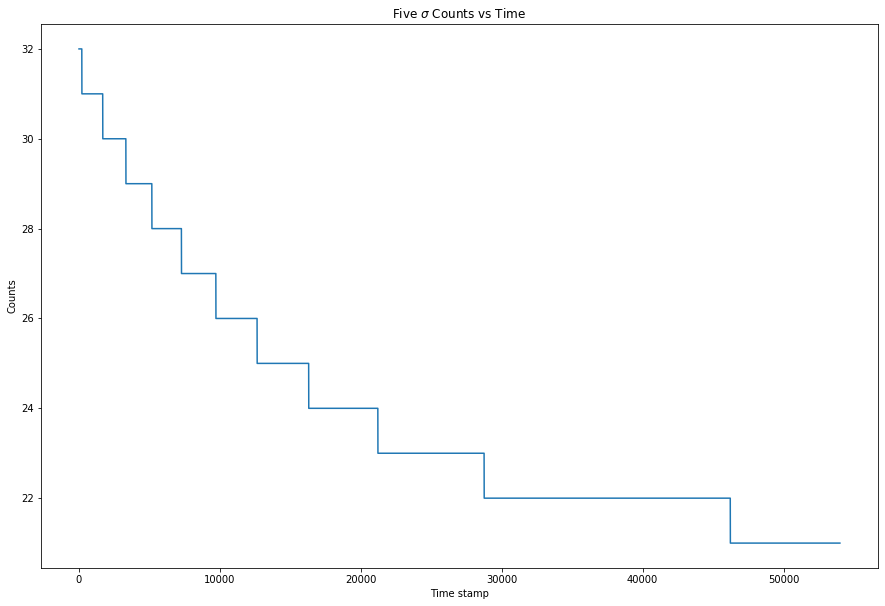

In [18]:
fiveSigmaProb = stats.norm.cdf(5, loc=0, scale=1)

times = []
counts = []

for time in range(0, oneOrbit, 1):
    times.append(time)
    mean = exponential_func(time, *p_opt)
    fiveSigmaSignal = stats.poisson.ppf(fiveSigmaProb, mu=mean)
    counts.append(fiveSigmaSignal)
    
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

ax.plot(times, counts)
ax.set_title("Five $\sigma$ Counts vs Time")
ax.set_xlabel("Time stamp")
ax.set_ylabel("Counts")

As we can see, right after the anomaly, the five-sigma threshold is 32, by the time we reach the end of the orbit, the five-sigma threshold drops to 21 counts.

After doing some research, it appears that this anomaly is known as the "South Atlantic Anomaly" which is caused by the Van Allen radiation belt being closer to the Earth's surface there than in other areas.

## Problem 2

> In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question. 

For this problem, I am workig with the problem of finding the dimmest stars in the images.

In [19]:
hf = h5py.File('images.h5', 'r')
print(hf.keys())
image1_data = np.array(hf.get('image1'))
images_data = np.array(hf.get('imagestack'))
hf.close()

<KeysViewHDF5 ['image1', 'imagestack']>


Text(0.5, 1.0, 'Average Image')

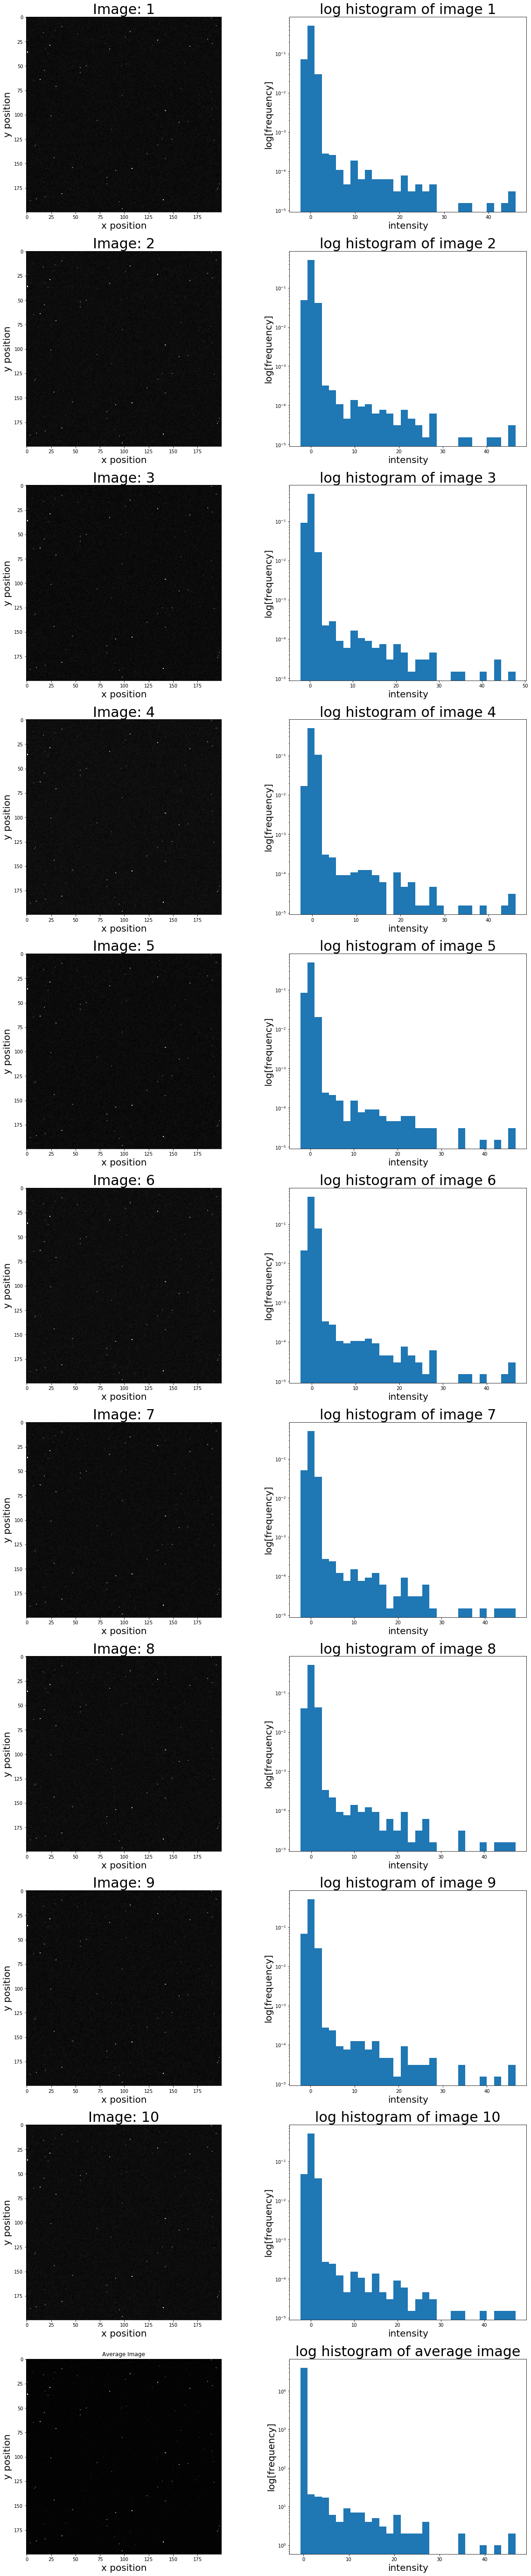

In [20]:
fig, ax = plt.subplots(11, 2)
fig.set_size_inches(20,100)



for image in range(10):
    title = 'Image: ' + str(image + 1)
    ax[image,0].set_title(title, fontsize=30)
    ax[image,0].set_xlabel('x position', fontsize=20)
    ax[image,0].set_ylabel('y position', fontsize=20)
    ax[image,0].imshow(images_data[:,:,image], cmap='gray')
    data = []
    for x in range(200):
        for y in range(200):
            data.append(images_data[x,y,image])
        
    ax[image,1].hist(data, density=True, bins = 30)
    ax[image,1].set_yscale('log')
    ax[image,1].set_title('log histogram of image ' + str(image + 1), fontsize=30)
    ax[image,1].set_xlabel('intensity', fontsize=20)
    ax[image,1].set_ylabel('log[frequency]', fontsize=20)

    
image_average = np.zeros([200, 200])
total_data = np.zeros(200*200)
for x in range(200):
    for y in range(200):
        average = np.average(images_data[x,y,:])
        image_average[x,y] = average
        total_data[x*200 + y] = average
        
ax[10, 0].imshow(image_average, cmap='gray')
ax[10, 1].hist(total_data, bins = 30)
ax[10, 1].set_yscale('log')
ax[10, 1].set_xlabel('intensity', fontsize=20)
ax[10, 1].set_ylabel('log[frequency]', fontsize=20)
ax[10, 1].set_title('log histogram of average image', fontsize=30)
ax[10, 0].set_xlabel('x position', fontsize=20)
ax[10, 0].set_ylabel('y position', fontsize=20)
ax[10, 0].set_title("Average Image")

We can see significant outliers by looking at either the raw image or the histogram.  It appears that there are a lot of points that have intensities less than 30, but very few above.  The points above 30 are changing in each picture, so those are probably transients (which are explored by my partner).  It also appears that the background drops off after an intensity of about 2.5.  We can trim the data below this 2.5 point to find the noise distribution.  Spatially, we see some bright spots, but mostly blackness.  The black spots are pixels where no significant data is collected (except for signal contamination from the CCD) and the bright spots are stars and other astronomical bodies of interest.

0.17755486102473308
maximum:  46.80528821379001
minimum:  -0.7133615480180917
sigma: 0.17755486102473308


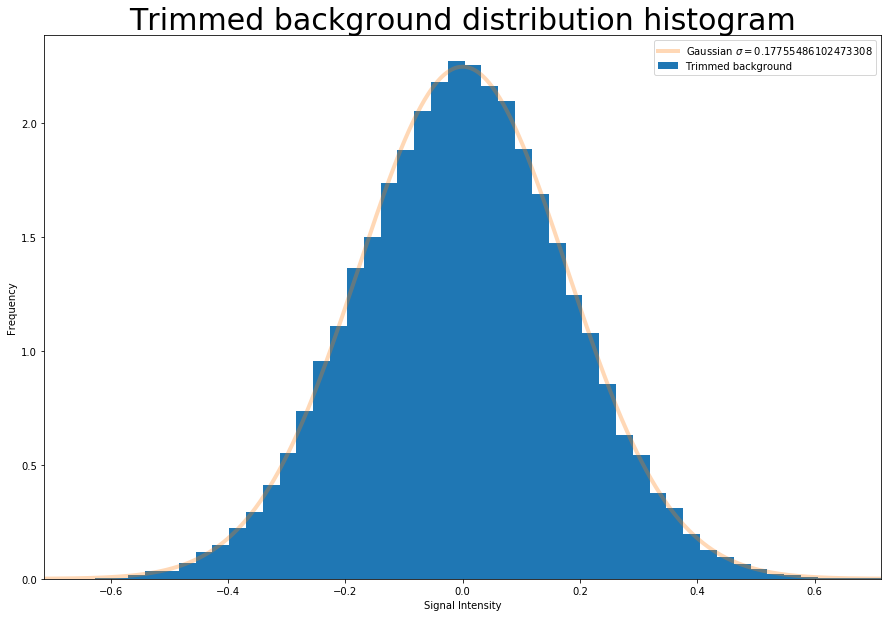

In [21]:
trimmed_data = []
minimum = 100000
maximum = 0

for point in total_data:
    if point < 0.72 and point > -2.5:
        trimmed_data.append(point)
    if point > maximum:
        maximum = point
    if point < minimum:
            minimum = point
        
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

hist = ax.hist(trimmed_data, density=True, bins=50,label="Trimmed background")
xVals = np.linspace(-1, 1, 1000)

sigma = np.std(trimmed_data)

print(sigma)

label_text = 'Gaussian $\sigma=$' + str(sigma)

ax.plot(xVals, stats.norm.pdf(xVals, scale=sigma, loc=0), linewidth = 4, alpha = 0.3, label=label_text)
ax.set_xlabel('Signal Intensity')
ax.set_ylabel('Frequency')
ax.set_title('Trimmed background distribution histogram', fontsize = 30)
plt.xlim([minimum,-1*minimum])
plt.legend()

print("maximum: ",maximum)
print('minimum: ', minimum)
print('sigma:',sigma)

So now we know that our background distribution can be estimated by a Gaussian distribution with $\sigma = 0.178$ and average = 0.  Since I am looking for faint stars, I want to compile all of the data points that are greater than $5\sigma$ above the mean of the background and find the low end of those points.

Text(0.5, 0, 'Intensity')

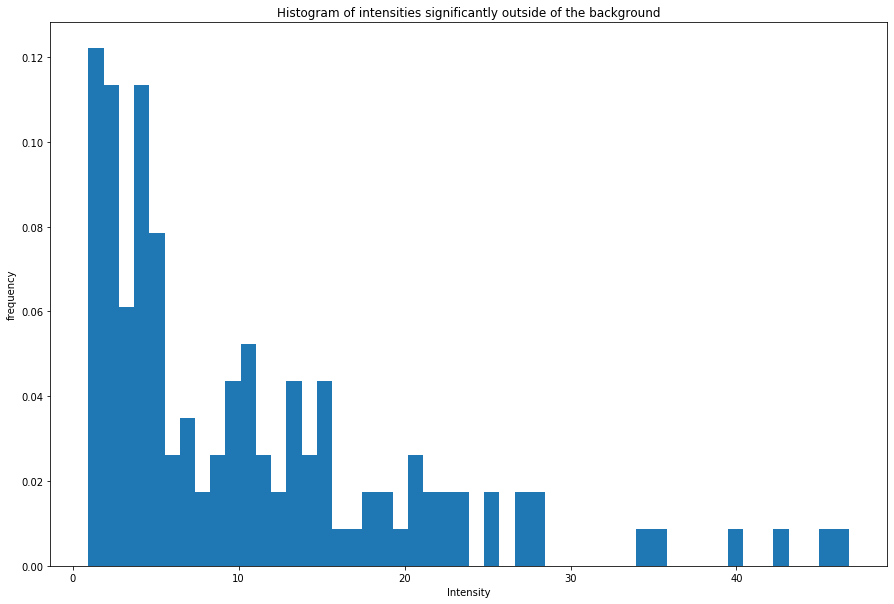

In [22]:
star_intensities = []
locationsX = []
locationsY = []

for x in range(200):
    for y in range(200):
        point = image_average[x, y]
        if point > 5*sigma:
            star_intensities.append(point)
            locationsX.append(x)
            locationsY.append(y)
                
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)
hist = ax.hist(star_intensities, bins = 50, density=True)
ax.set_title("Histogram of intensities significantly outside of the background")
ax.set_ylabel('frequency')
ax.set_xlabel('Intensity')

I am arbitrarily going to decide that I want to find the ten dimmest stars in the image

In [23]:
star_intensities.sort()
print(star_intensities[10])

1.7002808500177853


So the dimmest stars have an intensity of about 1.7.  Using this, we can now find the locations of the dimmest stars.

star # 1
	intensity 1.6218860566732025
	(x,y): ( 21 , 106 )
star # 2
	intensity 0.9546071388302602
	(x,y): ( 25 , 143 )
star # 3
	intensity 1.4372473179038958
	(x,y): ( 55 , 178 )
star # 4
	intensity 1.5934994581141915
	(x,y): ( 61 , 54 )
star # 5
	intensity 1.397459957814674
	(x,y): ( 139 , 138 )
star # 6
	intensity 1.371735310917744
	(x,y): ( 142 , 107 )
star # 7
	intensity 1.161759626948204
	(x,y): ( 152 , 116 )
star # 8
	intensity 1.2046732432743374
	(x,y): ( 163 , 112 )
star # 9
	intensity 1.3445730930701596
	(x,y): ( 164 , 36 )
star # 10
	intensity 1.031946159833744
	(x,y): ( 186 , 164 )


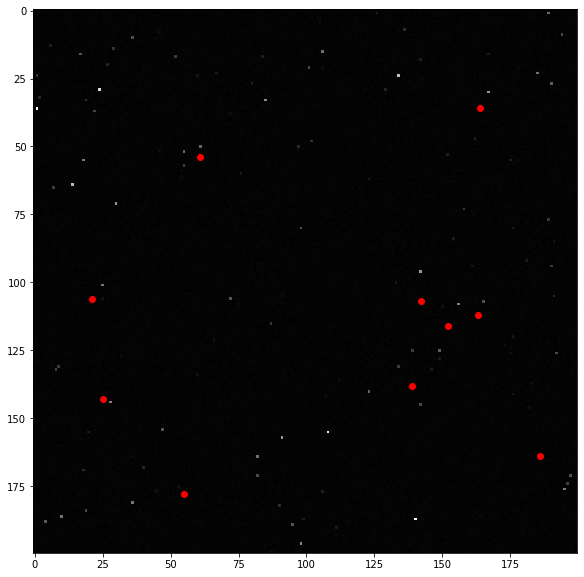

In [24]:
minimum = 5*sigma
maximum = star_intensities[10]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,10)

ax.imshow(image_average, cmap='gray')

star = 1

for x in range(200):
    for y in range(200):
        point = image_average[x, y]
        if point > minimum and point < maximum:
            print('star #',star)
            print('\tintensity',point)
            print('\t(x,y): (',x,',',y,')')
            ax.plot(x, y, 'ro')
            star += 1
                

Each red point corrosponds to one of the 10 dimmest stars in the image

The reason that my partner came up with a different background distribution than I did is because they were dealing with a different statistical question.  Mine regarded dim stars that appeared accross the images, so my background was just the noise.  My partner was dealing with transients, so they had to consider each image individually to figure out which bright spots only appear in certain images.